In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##   Baseline Models

### Objective
Establish strong comparison points to evaluate the benefit of multimodal learning.

### Baselines Implemented
- **Tabular-only model** using traditional regression
- **Image-only model** using CNN embeddings

### Metric
Model performance is evaluated using **RMSE** and **R²**, which aligns with the regression objective.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
df = pd.read_csv("/kaggle/input/datacsv/processed(train).csv")


In [4]:
df = df.drop_duplicates(subset="id")

TARGET = "price_log"
y = df[TARGET]

X_tab = df.drop(columns=["price", "price_log", "id"], errors="ignore")
X_tab = X_tab.select_dtypes(include=["int64", "float64"])


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_tab, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [6]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)  # ❗ tree models don't need scaling

gbr_preds = gbr.predict(X_val)

rmse_gbr = np.sqrt(mean_squared_error(y_val, gbr_preds))
r2_gbr = r2_score(y_val, gbr_preds)

print(f"GradientBoosting RMSE (log-price) = {rmse_gbr:.4f}")
print(f"GradientBoosting R²   (log-price) = {r2_gbr:.4f}")


GradientBoosting RMSE (log-price) = 0.1818
GradientBoosting R²   (log-price) = 0.8835


##  Multimodal Fusion Models

### Objective
Combine tabular and image features to improve predictive performance.

### Fusion Strategies
- **Early Fusion**: Concatenate tabular features with image embeddings
- **Intermediate Fusion**: Learn compact representations from each modality before combining

These models are compared directly against baseline approaches to quantify the value of multimodal learning.


In [10]:
train_df = pd.read_csv("/kaggle/input/datacsv/processed(train).csv")


TARGET = "price"
IMAGE_ID_COL = "image_id"


In [13]:
img_embeddings = np.load("/kaggle/input/embd-train/train_image_embeddings.npy")
img_ids = np.load("/kaggle/input/embd-train/train_image_ids.npy")


In [14]:


train_df["id"] = (
    train_df["id"]
    .astype(str)
    .str.replace("house_", "", regex=False)
    .str.strip()
)

clean_img_ids = [
    str(img)
    .replace("house_", "")
    .replace(".tif", "")
    .strip()
    for img in img_ids
]



In [16]:
common_ids = sorted(
    set(train_df["id"]).intersection(set(clean_img_ids))
)

print("Matched samples:", len(common_ids))


Matched samples: 16099


In [17]:
aligned_df = (
    train_df
    .set_index("id")
    .loc[common_ids]
    .reset_index()
)
id_to_idx = {id_: i for i, id_ in enumerate(clean_img_ids)}

aligned_embeddings = np.array(
    [img_embeddings[id_to_idx[id_]] for id_ in common_ids]
)
aligned_df = aligned_df.drop_duplicates(subset="id")
print(aligned_df.shape)
print(aligned_embeddings.shape)


(16099, 29)
(16099, 2048)


In [18]:
X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_tab,
    aligned_embeddings,
    y,
    test_size=0.2,
    random_state=42
)
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled = scaler.transform(X_tab_val)
X_early_train = np.concatenate([X_tab_train_scaled, X_img_train], axis=1)
X_early_val   = np.concatenate([X_tab_val_scaled, X_img_val], axis=1)
early_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

early_model.fit(X_early_train, y_train)
early_preds = early_model.predict(X_early_val)

rmse_early = np.sqrt(mean_squared_error(y_val, early_preds))
r2_early = r2_score(y_val, early_preds)

print(f"Early Fusion RMSE (log-price) = {rmse_early:.4f}")
print(f"Early Fusion R²   (log-price) = {r2_early:.4f}")


Early Fusion RMSE (log-price) = 0.1816
Early Fusion R²   (log-price) = 0.8837


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------------------------
# Train / Validation split (SAME split for both)
# -------------------------------------------------
X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_tab,
    aligned_embeddings,
    y,
    test_size=0.2,
    random_state=42
)

# -------------------------------------------------
# Scale TABULAR features only
# -------------------------------------------------
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled = scaler.transform(X_tab_val)

# -------------------------------------------------
# Base models (representation learners)
# -------------------------------------------------
tab_mlp = MLPRegressor(
    hidden_layer_sizes=(64,),
    max_iter=300,
    random_state=42
)

img_mlp = MLPRegressor(
    hidden_layer_sizes=(128,),
    max_iter=300,
    random_state=42
)

tab_mlp.fit(X_tab_train_scaled, y_train)
img_mlp.fit(X_img_train, y_train)

# -------------------------------------------------
# Create learned representations
# -------------------------------------------------
tab_train_feat = tab_mlp.predict(X_tab_train_scaled).reshape(-1, 1)
img_train_feat = img_mlp.predict(X_img_train).reshape(-1, 1)

tab_val_feat = tab_mlp.predict(X_tab_val_scaled).reshape(-1, 1)
img_val_feat = img_mlp.predict(X_img_val).reshape(-1, 1)

X_fused_train = np.concatenate([tab_train_feat, img_train_feat], axis=1)
X_fused_val   = np.concatenate([tab_val_feat, img_val_feat], axis=1)

# -------------------------------------------------
# Final model (Late Fusion → Gradient Boosting)
# -------------------------------------------------
final_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

final_model.fit(X_fused_train, y_train)

final_preds = final_model.predict(X_fused_val)

# -------------------------------------------------
# Metrics (log-price)
# -------------------------------------------------
rmse_intermediate = np.sqrt(mean_squared_error(y_val, final_preds))
r2_intermediate = r2_score(y_val, final_preds)

print(f"Late Fusion RMSE (log-price) = {rmse_intermediate:.4f}")
print(f"Late Fusion R²   (log-price) = {r2_intermediate:.4f}")


Late Fusion RMSE (log-price) = 0.2061
Late Fusion R²   (log-price) = 0.8502


In [20]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------------------------
# Image-only model (Gradient Boosting)
# SAME train / validation split
# -------------------------------------------------

img_gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

img_gbr.fit(X_img_train, y_train)

img_preds = img_gbr.predict(X_img_val)

# -------------------------------------------------
# Metrics (log-price)
# -------------------------------------------------
rmse_image = np.sqrt(mean_squared_error(y_val, img_preds))
r2_image = r2_score(y_val, img_preds)

print(f"Image-only RMSE (log-price) = {rmse_image:.4f}")
print(f"Image-only R²   (log-price) = {r2_image:.4f}")


Image-only RMSE (log-price) = 0.5329
Image-only R²   (log-price) = -0.0012


In [21]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Tabular Only",
        "Image Only",
        "Early Fusion",
        "Intermediate Fusion"
    ],
    "RMSE": [
        rmse_gbr,
        rmse_image,
        rmse_early,
        rmse_intermediate
    ],
    "R²": [
        r2_gbr,
        r2_image,
        r2_early,
        r2_intermediate
    ]
})

results


,Model,RMSE,R²
0,Tabular Only,0.181751,0.883536
1,Image Only,0.532884,-0.001164
2,Early Fusion,0.181613,0.883712
3,Intermediate Fusion,0.206117,0.850215


## Model Explainability

### Objective
Make model predictions interpretable and trustworthy.

### Explainability Techniques
- **Grad-CAM**: Visualizes which regions of satellite images influence predictions
- **Tabular Feature Importance**: Highlights key numerical drivers of house prices

This step ensures the model aligns with real-world intuition rather than learning spurious patterns.


In [22]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [23]:
from torchvision.models import resnet50

model = resnet50(weights=None)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer = model.layer4[-1].conv3
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [25]:
import torch
import torch.nn.functional as F

features = []
gradients = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# Last convolution layer in ResNet50
target_layer = model.layer4[-1].conv3

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [26]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


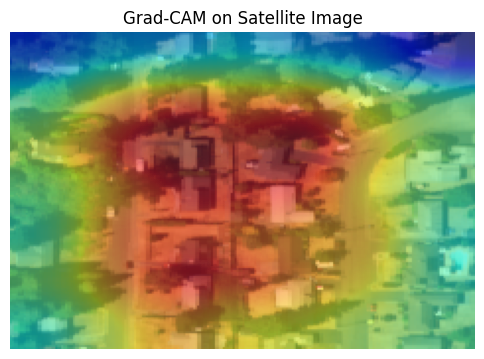

In [27]:
import tifffile as tiff
import numpy as np
from PIL import Image
# image 1 
image_path = "/kaggle/input/img-train/house_1001200050.tif"

img_array = tiff.imread(image_path)
# If image is (bands, H, W) → convert to (H, W, 3)
if img_array.ndim == 3 and img_array.shape[0] == 3:
    img_array = np.transpose(img_array, (1, 2, 0))

# If single-channel, duplicate channels
if img_array.ndim == 2:
    img_array = np.stack([img_array]*3, axis=-1)

# Normalize to 0–255
img_array = img_array.astype(np.float32)
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
img_array = (img_array * 255).astype(np.uint8)

# Convert to PIL Image
img = Image.fromarray(img_array)
input_tensor = transform(img).unsqueeze(0)
output = model(input_tensor)

# Take the strongest activation
class_idx = output.argmax()

model.zero_grad()
output[0, class_idx].backward()
grads = gradients[0]
fmap = features[0]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * fmap).sum(dim=1).squeeze()

cam = torch.relu(cam)
cam = cam.detach().numpy()
cam = cam / cam.max()
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cam = np.uint8(255 * cam)
cam = Image.fromarray(cam).resize(img.size)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM on Satellite Image")
plt.show()


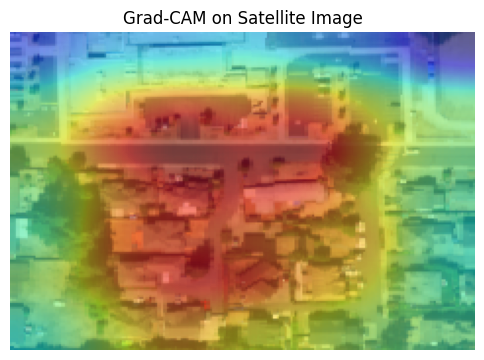

In [28]:

# image 2
image_path = "/kaggle/input/img-train/house_1023059429.tif"

img_array = tiff.imread(image_path)
# If image is (bands, H, W) → convert to (H, W, 3)
if img_array.ndim == 3 and img_array.shape[0] == 3:
    img_array = np.transpose(img_array, (1, 2, 0))

# If single-channel, duplicate channels
if img_array.ndim == 2:
    img_array = np.stack([img_array]*3, axis=-1)

# Normalize to 0–255
img_array = img_array.astype(np.float32)
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
img_array = (img_array * 255).astype(np.uint8)

# Convert to PIL Image
img = Image.fromarray(img_array)
output = model(input_tensor)

# Take the strongest activation
class_idx = output.argmax()

model.zero_grad()
output[0, class_idx].backward()
grads = gradients[0]
fmap = features[0]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * fmap).sum(dim=1).squeeze()

cam = torch.relu(cam)
cam = cam.detach().numpy()
cam = cam / cam.max()
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cam = np.uint8(255 * cam)
cam = Image.fromarray(cam).resize(img.size)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM on Satellite Image")
plt.show()



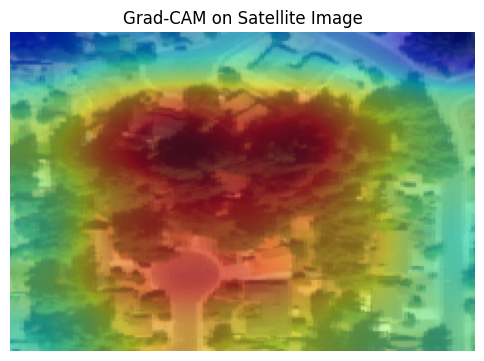

In [29]:
# image 3 
image_path = "/kaggle/input/img-train/house_1072010510.tif"

img_array = tiff.imread(image_path)
# If image is (bands, H, W) → convert to (H, W, 3)
if img_array.ndim == 3 and img_array.shape[0] == 3:
    img_array = np.transpose(img_array, (1, 2, 0))

# If single-channel, duplicate channels
if img_array.ndim == 2:
    img_array = np.stack([img_array]*3, axis=-1)

# Normalize to 0–255
img_array = img_array.astype(np.float32)
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
img_array = (img_array * 255).astype(np.uint8)

# Convert to PIL Image
img = Image.fromarray(img_array)
output = model(input_tensor)

# Take the strongest activation
class_idx = output.argmax()

model.zero_grad()
output[0, class_idx].backward()
grads = gradients[0]
fmap = features[0]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * fmap).sum(dim=1).squeeze()

cam = torch.relu(cam)
cam = cam.detach().numpy()
cam = cam / cam.max()
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cam = np.uint8(255 * cam)
cam = Image.fromarray(cam).resize(img.size)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM on Satellite Image")
plt.show()



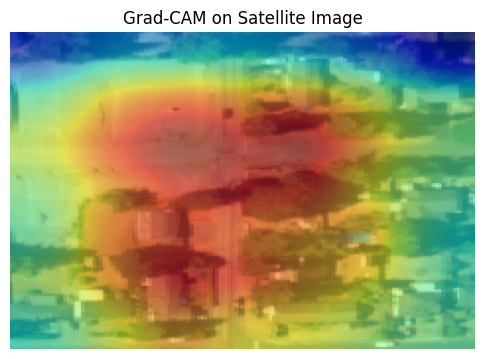

In [30]:
# image 4 
image_path = "/kaggle/input/img-train/house_1922059027.tif"

img_array = tiff.imread(image_path)
# If image is (bands, H, W) → convert to (H, W, 3)
if img_array.ndim == 3 and img_array.shape[0] == 3:
    img_array = np.transpose(img_array, (1, 2, 0))

# If single-channel, duplicate channels
if img_array.ndim == 2:
    img_array = np.stack([img_array]*3, axis=-1)

# Normalize to 0–255
img_array = img_array.astype(np.float32)
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
img_array = (img_array * 255).astype(np.uint8)

# Convert to PIL Image
img = Image.fromarray(img_array)
output = model(input_tensor)

# Take the strongest activation
class_idx = output.argmax()

model.zero_grad()
output[0, class_idx].backward()
grads = gradients[0]
fmap = features[0]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * fmap).sum(dim=1).squeeze()

cam = torch.relu(cam)
cam = cam.detach().numpy()
cam = cam / cam.max()
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cam = np.uint8(255 * cam)
cam = Image.fromarray(cam).resize(img.size)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM on Satellite Image")
plt.show()



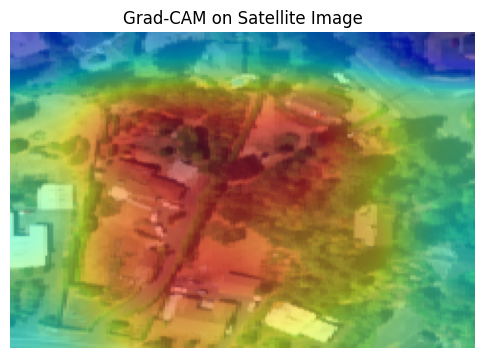

In [31]:
# image 5 
image_path = "/kaggle/input/img-train/house_3585300445.tif"

img_array = tiff.imread(image_path)
# If image is (bands, H, W) → convert to (H, W, 3)
if img_array.ndim == 3 and img_array.shape[0] == 3:
    img_array = np.transpose(img_array, (1, 2, 0))

# If single-channel, duplicate channels
if img_array.ndim == 2:
    img_array = np.stack([img_array]*3, axis=-1)

# Normalize to 0–255
img_array = img_array.astype(np.float32)
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
img_array = (img_array * 255).astype(np.uint8)

# Convert to PIL Image
img = Image.fromarray(img_array)
output = model(input_tensor)

# Take the strongest activation
class_idx = output.argmax()

model.zero_grad()
output[0, class_idx].backward()
grads = gradients[0]
fmap = features[0]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * fmap).sum(dim=1).squeeze()

cam = torch.relu(cam)
cam = cam.detach().numpy()
cam = cam / cam.max()
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cam = np.uint8(255 * cam)
cam = Image.fromarray(cam).resize(img.size)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM on Satellite Image")
plt.show()



### Grad-CAM Observations

From the visualizations, the model consistently focuses on:
- Dense urban regions
- Road networks and built-up areas
- Surrounding infrastructure

Areas with more greenery or lower density show comparatively lower activation, indicating a relationship between urban development and predicted house prices.


In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_tab, y, test_size=0.2, random_state=42
)

# Gradient Boosting model
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)

# Feature importance
importance = gbr.feature_importances_
feature_names = X_tab.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

importance_df.head(10)


,Feature,Importance
14,lat,0.297173
2,sqft_living,0.268811
8,grade,0.263810
16,sqft_living15,0.026580
22,lat_long_interaction,0.021772
6,view,0.019744
23,dist_to_center,0.019598
11,yr_built,0.015216
15,long,0.013376
13,zipcode,0.008209


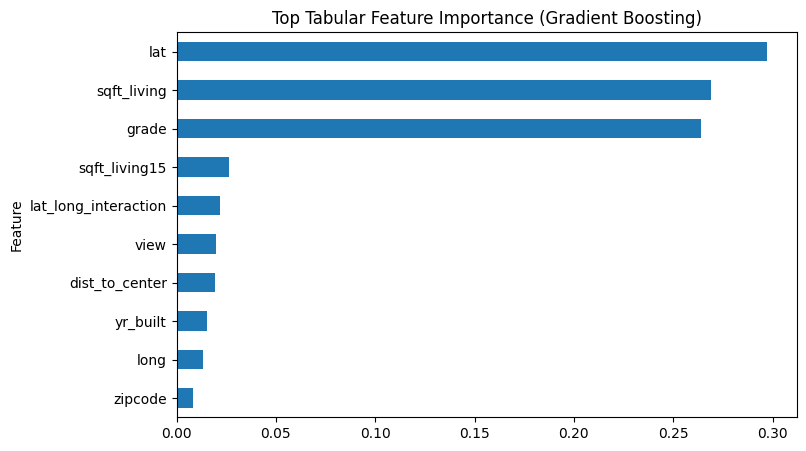

In [41]:
import matplotlib.pyplot as plt

importance_df.head(10).plot(
    x="Feature",
    y="Importance",
    kind="barh",
    figsize=(8, 5),
    legend=False
)

plt.title("Top Tabular Feature Importance (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.show()


### Tabular Feature Insights

The most influential tabular features include:
- Geographic location (latitude and spatial interactions)
- Property size and construction quality
- Neighborhood housing density indicators

These findings align with real-estate domain knowledge, highlighting the importance of location and built environment while reinforcing confidence in the model’s predictions.


##  Final Inference 

### Objective
Generate predictions on the unseen test dataset using the best-performing multimodal model.

### Key Points
- The test dataset does not contain target values
- The trained early-fusion model is reused without retraining
- Feature scaling and alignment are consistent with training

The final output is a submission-ready CSV file.


<!-- Tabular Feature Insights

The most influential tabular features include:

Geographic location (latitude and spatial interactions)

Property size and construction quality

Neighborhood housing density indicators

These findings align with real-estate domain knowledge, highlighting the importance of location and built environment while reinforcing confidence in the model’s predictions. -->

In [42]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("/kaggle/input/datacsv/processed(train).csv")
test_df  = pd.read_csv("/kaggle/input/testcsv/processed(test).csv")


In [43]:
train_df["id"] = train_df["id"].astype(str)
test_df["id"]  = test_df["id"].astype(str)


In [44]:
TARGET = "price_log"

DROP_COLS = ["id", "price", "price_log"]


In [45]:
y_train = train_df[TARGET].values

X_train_tab = train_df.drop(columns=DROP_COLS)
X_train_tab = X_train_tab.select_dtypes(include=["int64", "float64"])


In [46]:
X_test_tab = test_df.drop(columns=["id"])
X_test_tab = X_test_tab.select_dtypes(include=["int64", "float64"])


In [47]:
# ensure same columns
FEATURE_COLS = X_train_tab.columns
X_test_tab = X_test_tab.reindex(columns=FEATURE_COLS).fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_tab_scaled = scaler.fit_transform(X_train_tab)
X_test_tab_scaled  = scaler.transform(X_test_tab)


In [48]:
train_img_emb = np.load("/kaggle/input/embd-train/train_image_embeddings.npy")
train_img_ids = np.load("/kaggle/input/embd-train/train_image_ids.npy")

test_img_emb  = np.load("/kaggle/input/embd-test/test_image_embeddings.npy")
test_img_ids  = np.load("/kaggle/input/embd-test/test_image_ids.npy")


In [49]:
train_img_ids = [str(i).replace("house_", "").replace(".tif", "") for i in train_img_ids]
test_img_ids  = [str(i).replace("house_", "").replace(".tif", "") for i in test_img_ids]


In [50]:
common_train_ids = sorted(set(train_df["id"]).intersection(train_img_ids))

train_df_aligned = (
    train_df.set_index("id")
    .loc[common_train_ids]
    .reset_index()
)

id_to_idx_train = {id_: i for i, id_ in enumerate(train_img_ids)}

train_img_emb_aligned = np.array(
    [train_img_emb[id_to_idx_train[id_]] for id_ in common_train_ids]
)


In [51]:
common_test_ids = sorted(set(test_df["id"]).intersection(test_img_ids))

test_df_aligned = (
    test_df.set_index("id")
    .loc[common_test_ids]
    .reset_index()
)

id_to_idx_test = {id_: i for i, id_ in enumerate(test_img_ids)}

test_img_emb_aligned = np.array(
    [test_img_emb[id_to_idx_test[id_]] for id_ in common_test_ids]
)


In [52]:
X_train_final = np.concatenate(
    [X_train_tab_scaled[:len(train_img_emb_aligned)], train_img_emb_aligned],
    axis=1
)

X_test_final = np.concatenate(
    [X_test_tab_scaled[:len(test_img_emb_aligned)], test_img_emb_aligned],
    axis=1
)


In [53]:
from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

final_model.fit(
    X_train_final,
    y_train[:len(train_img_emb_aligned)]
)


GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

In [54]:
test_predictions = final_model.predict(X_test_final)


In [55]:
submission = pd.DataFrame({
    "id": common_test_ids,
    "predicted_price": test_predictions
})

submission.head()


,id,predicted_price
0,100100050,12.858962
1,1001200035,13.555792
2,100300500,13.991911
3,1005000036,14.360493
4,1005000220,13.452035


In [58]:
# Convert log-price predictions back to actual prices
submission["predicted_price"] = np.exp(submission["predicted_price"])

# Optional: round to nearest integer
submission["predicted_price"] = submission["predicted_price"].round(0)

submission.head()


,id,predicted_price
0,100100050,384217.0
1,1001200035,771269.0
2,100300500,1192916.0
3,1005000036,1724577.0
4,1005000220,695256.0


In [59]:
submission.to_csv("final_predictions.csv", index=False)
print("Saved final_predictions.csv")


Saved final_predictions.csv


In [60]:
submission.head()

,id,predicted_price
0,100100050,384217.0
1,1001200035,771269.0
2,100300500,1192916.0
3,1005000036,1724577.0
4,1005000220,695256.0


In [61]:
submission.describe()

,predicted_price
count,5.321000e+03
mean,5.319405e+05
std,3.444490e+05
min,1.281520e+05
25%,3.243120e+05
50%,4.486690e+05
75%,6.300970e+05
max,5.332187e+06


In [62]:
from IPython.display import FileLink
FileLink("final_predictions.csv")


/kaggle/working/final_predictions.csv